#### Tweaking model - see if adding a third group helps this. using r/all as baseline. 

In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import requests
import json
import time
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#Getting and exploring Democrat and republican information
#Using the same cell to do the pulls to save some space

In [24]:
data_list = []
URL = "https://www.reddit.com/r/Republican/.json"
#seems to be a cap at 20
for step in range(20):
    res = requests.get(URL, headers={'User-agent': 'Conor Barry Bot 0.1'})
    data = res.json()
    
    for i in range(len(data['data']['children'])):
        temp = {}
        temp['subreddit'] = data['data']['children'][i]['data']['subreddit_name_prefixed'].replace('r/', '')
        temp['title']=data['data']['children'][i]['data']['title']
        temp['selftext'] = data['data']['children'][i]['data']['selftext']
        data_list.append(temp)

    new_after = data['data']['after']
    URL = "https://www.reddit.com/r/Republican/.json?after=" + new_after
    print('    iteration {} worked. URL: {}'.format(step, URL))
    time.sleep(3)
    
df_republicans_scrape = pd.DataFrame(data_list)
print('    size: ', df_republicans_scrape.shape)
df_republicans_scrape.head()

    iteration 0 worked. URL: https://www.reddit.com/r/Republican/.json?after=t3_9bpt7f
    iteration 1 worked. URL: https://www.reddit.com/r/Republican/.json?after=t3_9b6mn7
    iteration 2 worked. URL: https://www.reddit.com/r/Republican/.json?after=t3_9acujw
    iteration 3 worked. URL: https://www.reddit.com/r/Republican/.json?after=t3_99x53j
    iteration 4 worked. URL: https://www.reddit.com/r/Republican/.json?after=t3_99bxdv
    iteration 5 worked. URL: https://www.reddit.com/r/Republican/.json?after=t3_97zicr
    iteration 6 worked. URL: https://www.reddit.com/r/Republican/.json?after=t3_97y95a
    iteration 7 worked. URL: https://www.reddit.com/r/Republican/.json?after=t3_96zirr
    iteration 8 worked. URL: https://www.reddit.com/r/Republican/.json?after=t3_96axws
    iteration 9 worked. URL: https://www.reddit.com/r/Republican/.json?after=t3_95ocui
    iteration 10 worked. URL: https://www.reddit.com/r/Republican/.json?after=t3_95cjo7
    iteration 11 worked. URL: https://www.

,selftext,subreddit,title
0,,Republican,"How Socialism Rots The Soul, The Culture And T..."
1,,Republican,Florida primary 2018: A look at Central Florid...
2,,Republican,POOF HE’S GONE! MSNBC and ABC crop out Louis F...
3,,Republican,Neocons and liberals hate Trump because he has...
4,,Republican,John McCain's marriage was like a Hallmark Cha...


In [25]:
# Export to csv
df_republicans_scrape.to_csv('./Data/InitialRepublicanPosts_9_03.csv', index=False)

### Analysis picks up here

In [3]:
#Pick up CSVs after recorded. Dems First
df_dems_init = pd.read_csv('./Data/InitialDemocratsPosts_8_31.csv')
df_dems_new = pd.read_csv('./Data/InitialDemocratsPosts_9_03.csv')
df_democrats_all = df_dems_init.append(df_dems_new.iloc[1:, ], ignore_index=True)

df_reps_init = pd.read_csv('./Data/InitialRepublicanPosts.csv')
df_reps_new = pd.read_csv('./Data/InitialRepublicanPosts_9_03.csv')
df_republicans_all = df_reps_init.append(df_reps_new, ignore_index=True)

df_all_init = pd.read_csv('./Data/allPosts_9_04_A.csv')
df_cats_init = pd.read_csv('./Data/catsPosts_9_03_A.csv')
df_dogs_init = pd.read_csv('./Data/dogsPosts_9_03_A.csv')
df_hbb_init = pd.read_csv('./Data/hbbPosts_9_04_A.csv')

In [4]:
df_init_DemRep = df_democrats_all.append(df_republicans_all, ignore_index=True, verify_integrity=True)
for df in [df_all_init,df_cats_init, df_dogs_init, df_hbb_init]:
    df_init_DemRep =  df_init_DemRep.append(df, ignore_index=True, verify_integrity=True)
    

df_init_DemRep.shape

(4004, 3)

In [5]:
#Value counts check out. Looks like we got an extra Dem post from that locked post.
count = 0
[label for label in df_init_DemRep['subreddit'].value_counts().index if label =='democrats' or label =='Republican'] #no duplicates in r/all

['democrats', 'Republican']

In [6]:
df_init_DemRep['subred_cat'] = (df_init_DemRep['subreddit']=='democrats')*2 + (df_init_DemRep['subreddit']=='Republican')*1
df_init_DemRep.fillna(' ', inplace=True)
df_init_DemRep.isnull().sum()

selftext      0
subreddit     0
title         0
subred_cat    0
dtype: int64

In [7]:
df_init_DemRep['subred_cat'].value_counts()

0    2003
2    1001
1    1000
Name: subred_cat, dtype: int64

In [8]:
#Filling this in for later application to new subs, if I get to it
#Figures as of 8/30/2018
dem_subscribers = 66.2 #Thousand
reb_subscribers = 52.4 #Thousand
dem_prior = dem_subscribers / (dem_subscribers + reb_subscribers)
rep_prior = 1 - dem_prior
dem_prior

0.5581787521079259

In [13]:
#Loosely correlates to 2016 presidential election number of 51%
#Lower Figure here jives with qualitative assumption that reddit leans democrat a little more

#### Conor's Gameplan

1. Get Dems, repubs into single frame
    1a. Convert data
    1b. Temporarily downselect titles only
2. Run logit
3. Answer basic questions
4. Create separate title vector (with word_ format for feature names) for each
5. Collect these together to one mega frame and re-rune
6. Synthesize Democrat / Republican-ness

#### SEE V1 in folder for all the lab specific questions and executive summary.
#### This document is focused on developing additional analysis and scoring for 3rd party subreddits
##### Which is the focus of my intended blog post.

In [9]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import stop_words
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import seaborn as sns

In [10]:
my_stop_words = stop_words.ENGLISH_STOP_WORDS

In [11]:
#no compelling reason to pull in self-text
df_data = df_init_DemRep.loc[:, ['subred_cat', 'title']]

In [12]:
def fit_transform_model(X=df_data.title, y=df_data.subred_cat, 
                        vecmod='TFID', pred='logreg', 
                        test_size_local=None, random_state_local=42 ):
    """I absolutely created this function after running through the lab the first time. 
    I figured that it would help me clean up the rest of the document, as well as making
    additions to the model.
    With a little bit of work, this should be very generalizable to future models for me."""
    
    #get vectorizer
    if vecmod == 'TFID':
        vecmod_ = TfidfVectorizer(stop_words=my_stop_words, ngram_range=(1,3))
    else:
        vecmod_ = vecmod
    
    #TTS, 
    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                        test_size=test_size_local, 
                                                        random_state=random_state_local)
    X_train_transform = vecmod_.fit_transform(X_train).todense()
    df_X_train_transform = pd.DataFrame(X_train_transform, columns=vecmod_.get_feature_names())
    X_test_transform = vecmod_.transform(X_test).todense()
    df_X_test_transform = pd.DataFrame(X_test_transform, columns=vecmod_.get_feature_names())
    
    #predict model
    if pred == 'logreg':
        funct_model_= LogisticRegression()
    else:
        funct_model_ = pred
        
    funct_model_.fit(df_X_train_transform, y_train)
    
    #Export features and scores
    global latest_model, latest_transform, sorted_d_values_none, sorted_d_values_rep, sorted_d_values_dem, train_x, test_x, test_y, train_y
    latest_model = funct_model_ 
    train_x, test_x, train_y, test_y = df_X_train_transform, df_X_test_transform, y_train, y_test
    latest_transform = vecmod_
    
    try:
        feature_values_none =(dict(zip(list(df_X_train_transform.columns), list(funct_model_.coef_[0]))))
        sorted_d_values_none = sorted({(value, key) for (key,value) in feature_values_none.items()}, reverse=True)
        
        feature_values_rep =(dict(zip(list(df_X_train_transform.columns), list(funct_model_.coef_[1]))))
        sorted_d_values_rep = sorted({(value, key) for (key,value) in feature_values_rep.items()}, reverse=True)
        
        feature_values_dem =(dict(zip(list(df_X_train_transform.columns), list(funct_model_.coef_[2]))))
        sorted_d_values_dem = sorted({(value, key) for (key,value) in feature_values_dem.items()}, reverse=True)

    except:
        print('   broken')
        return funct_model_.score(df_X_test_transform, y_test)
    
    return funct_model_.score(df_X_test_transform, y_test)

In [13]:
fit_transform_model(test_size_local=.2)

0.8014981273408239

In [14]:
print('   none indicators:')
for i in range(10):
    print('    ', sorted_d_values_none[i])
#print('    democratic indicators: ', sorted_d[:-10])
print('\n    rep indicators:')
for i in range(10):
    print('    ', sorted_d_values_rep[i])
print('\n    dem indicators:')
for i in range(10):
    print('    ', sorted_d_values_dem[i])

   none indicators:
     (5.611738448785891, 'help')
     (3.9711631418586015, 'dog')
     (3.127261765291027, 'cat')
     (2.57944795429636, 'discussion')
     (1.876685001273597, 'dogs')
     (1.811047702858205, 'breeds')
     (1.5562430995005374, 'breed')
     (1.4505424076744973, 'little')
     (1.4223197142199957, 'old')
     (1.3140248902515075, 'love')

    rep indicators:
     (1.8117442133225576, 'liberals')
     (1.6367265811688123, 'senate')
     (1.585471302796486, 'walkaway')
     (1.3890949271144213, 'hc')
     (1.3869125345202595, 'brennan')
     (1.3669681607886188, 'media')
     (1.3397263388347898, 'republican')
     (1.3317468293628683, 'left')
     (1.3179722493103019, 'socialism')
     (1.2137656494541853, 'gop')

    dem indicators:
     (7.177275355534448, 'trump')
     (3.4461724377327134, 'president')
     (2.993538142074914, 'mccain')
     (2.5007589979018023, 'kavanaugh')
     (2.459963898494526, 'twitter')
     (2.3702938426215443, 'republicans')
     (2.236

In [15]:
cm = confusion_matrix(test_y, latest_model.predict(test_x))
df_cm = pd.DataFrame(cm, columns=['Predicted None', 'Pred Rep', 'Pred Dem'], index=['Actual None', 'Actual Rep', 'Actual Dem'])
df_cm

,Predicted None,Pred Rep,Pred Dem
Actual None,373,2,2
Actual Rep,86,108,18
Actual Dem,43,8,161


In [ ]:
'''This has much fewer false positives in the target values, which we like a lot for our purposes. 
Would much rather overclassify none so we can be sure of Dem/Rep predicted ratio in our subs'''

# Executive Summary
---
### The Need

YOU are a totally legitimate campaign strategy group (and not at all a nefarious foreign entity).     

YOU **NEED** to expand your voter turnout numbers by identifying low-key voters who would support you, but eschew venues by which you would normally reach out to them (e.g. Facebook).   
  
YOU are smart and cautious, having seen how a misplaced ad or statement can be easily twisted to support the other side, and want to make sure your ads are interpreted as intended.
  
 So where are these voters?? How do you mine them and find them without stepping on mines?
 
 ### The solution
 Introducing **The HUAC 9000**   
 
 Named for the infamous and (occaisionally) successful communist hunting committee of the 1950s, the HUAC 9000 uses data from thousands of known Democratic and Republican posts to ferret out party-line sentiment hidden under benign cat-posts.   
   
The HUAC 9000 can identify party leanings and the strength of those leanings in an easy to interpret score, saving you time and precious resources by increasing the effectiveness of ads. 
  
  
### We can do it
Our team has years of cumulative experience getting blind-sided by uncomfortable political conversations that seem to erupt out of nowhere. Exasperated that it was becoming impossible to talk about anything nice for more than 5 minutes, our team (consisting of top 50 Kaggle scoreres in the Ames Iowa competition and codewars veterans rank 5 or higher) spent uncountable hours fine-tuning the HUAC. 
  
  
### Now is the Time
Our team of trained experts will stand up a HUAC 9000 implementation tuned to your candidate, and teach you to search Reddit to find your supporters. No one is looking over your shoulder ;), meaning you have more time to focus on what matters.  
  
  
If they can vote for Laurel or Yonny, they can vote for your candidate. Don't let them get away - buy HUAC 9000 Today.


## Collection of Executive Summary information
Includes final model refit.

In [27]:
#!pip install wordcloud

In [28]:
#https://www.geeksforgeeks.org/generating-word-cloud-python/

In [14]:
from wordcloud import WordCloud

In [116]:
fit_transform_model(test_size_local=.2, vecmod=TfidfVectorizer(stop_words=my_stop_words,
                                           ngram_range = (1,3), 
                                           binary=False))

0.8014981273408239

In [117]:
latest_model.intercept_ #Democrat intercept is more penalizing

array([ 0.2303148 , -1.2202583 , -1.43678538])

In [113]:
none_word_dict = dict(sorted_d_values_none[:21])
rep_word_dict = dict(sorted_d_values_rep[:50])
dem_word_dict = dict(sorted(sorted_d_values_dem[:50]))

In [114]:
dem_word_dict

{0.9200119571011498: 'plan',
 0.9211669441606003: 'americans',
 0.9232880195470916: 'presidency',
 0.9372728830868112: 'american',
 0.9537001104968201: 'federal',
 0.9547024296379086: 'voters',
 0.9760098586189271: 'bernie dog',
 0.9845996854658801: 'congress',
 0.9890863412762834: 'people',
 0.9893496364005863: 'manafort',
 1.0060938379972262: 'obama',
 1.008068542848371: 'john mccain',
 1.0101121409073528: 'hillary clinton',
 1.0674986640826678: 'hillary',
 1.091210161323053: 'fox',
 1.0931415885632183: 'donald trump',
 1.1069704423130518: 'fox news',
 1.1225167926592103: 'truth',
 1.1299381809216908: 'news',
 1.140096560488081: 'election',
 1.1448910716121854: 'shickenchit',
 1.14951506741368: 'donald',
 1.1714521982268888: 'party',
 1.1719162277716462: 'impeachment',
 1.187932367577727: 'house',
 1.192305777550084: 'clinton',
 1.2027461898315968: 'mueller',
 1.204229086443322: 'democratic',
 1.2068159038271542: 'bernie',
 1.2141852363383718: 'corruption',
 1.217290962432202: 'gillu

In [33]:
len(rep_word_dict)

20

In [18]:
from math import exp
import random

In [19]:
rep_word_dict_trans = {}
for key in rep_word_dict.keys():
    new_key_= int(exp(-key)*2000) #watch out for this negative
    while new_key_ in rep_word_dict.keys():
        new_key_+=1 #tie breaker prevents override of values
        print('    ',new_key_)
    rep_word_dict_trans[new_key_] = rep_word_dict[key]
rep_words_str = ''
for key in rep_word_dict_trans.keys():
    rep_words_str = rep_words_str + key*(str(rep_word_dict_trans[key]) + ' ')

In [20]:
dem_word_dict_trans = {}
for key in dem_word_dict.keys():
    new_key_= int(exp(key)*2000)
    while new_key_ in dem_word_dict.keys():
        new_key_+=1
        print('    ',new_key_)
    dem_word_dict_trans[new_key_] = dem_word_dict[key]
dem_words_str = ''
for key in dem_word_dict_trans.keys():
    dem_words_str = dem_words_str + key*(str(dem_word_dict_trans[key]) + ' ')
dem_word_dict_trans

{6735: 'corruption',
 6756: 'gillum',
 6859: '2020',
 7189: 'administration',
 7747: 'say',
 7861: 'john',
 7879: 'campaign',
 8289: 'white house',
 8940: 'cohen',
 9165: 'white',
 9736: 'beto rourke',
 9990: 'beto',
 10413: 'gop',
 11616: 'rourke',
 18713: 'democrats',
 21401: 'republicans',
 23408: 'twitter',
 24383: 'kavanaugh',
 39912: 'mccain',
 62760: 'president',
 2618671: 'trump'}

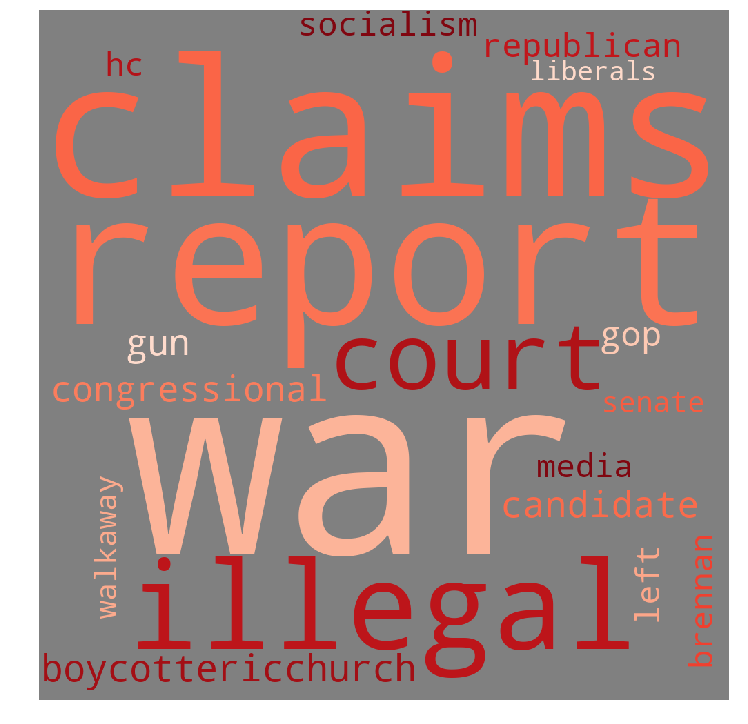

In [88]:
mycloud = WordCloud(width=1000, height=1000,
                    background_color='grey', 
                    colormap='Reds',
                    min_font_size=1,
                    max_words=len(rep_words_str),
                    collocations=False, #get rid of duplicates
                   normalize_plurals=False).generate_from_text(rep_words_str)
plt.figure(figsize = (10, 10), facecolor = None)
plt.imshow(mycloud)
plt.axis("off")
plt.tight_layout(pad = 0)
mycloud.to_file('./Presentation/OutputFigs/RepCloud_3.png')

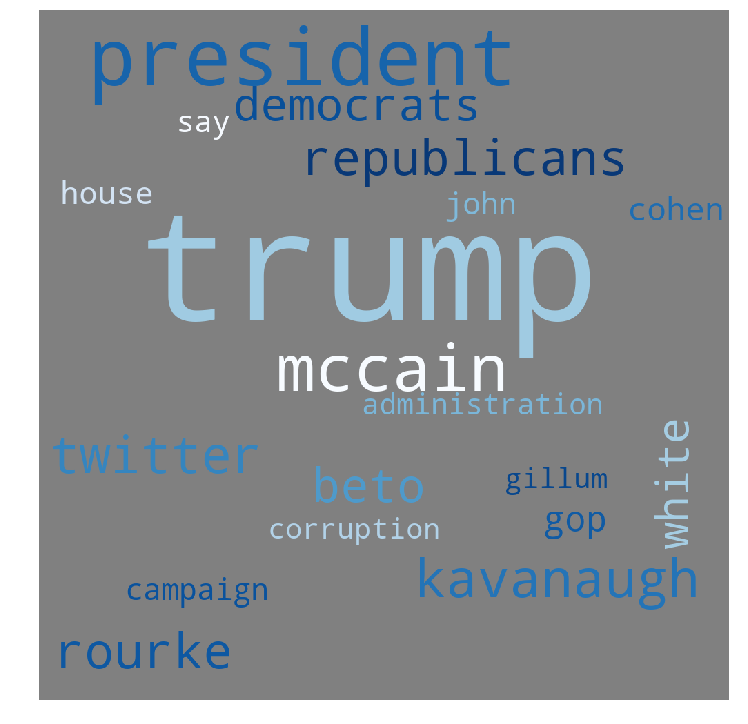

In [21]:
mycloud = WordCloud(width=1000, height=1000,
                    background_color='grey', 
                    min_font_size=1,
                    colormap='Blues',
                    collocations=False, #get rid of duplicates
                   normalize_plurals=False,
                   max_words=len(dem_words_str)).generate_from_text(dem_words_str)
plt.figure(figsize = (10, 10), facecolor = None)
plt.imshow(mycloud)
plt.axis("off")
plt.tight_layout(pad = 0)
mycloud.to_file('./Presentation/OutputFigs/DemCloud_3.png')

In [ ]:
#Talk about overlap - words more tightly clustered for republican/

   demwords: 2297
   repwords: 1791
    4088


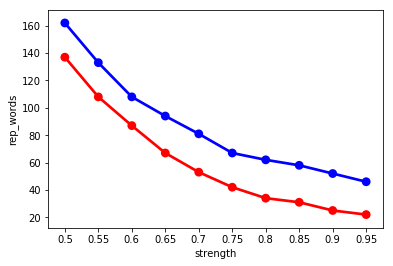

In [30]:
#How many words are above a given 'stregnth' score for dems vs. republicans
all_rep_words = { key:dict(sorted_d_values_rep)[key] for key in dict(sorted_d_values_rep).keys() if key>0 }
all_dem_words = { key:dict(sorted_d_values_dem)[key] for key in dict(sorted_d_values_dem).keys() if key>0 }
print('   demwords:', len(all_dem_words))
print('   repwords:', len(all_rep_words))
print('   ', len(all_rep_words)+len(all_dem_words))

results_list = []
for i in range(50,100, 5):
    j = i/100
    temp_dict = {}
    temp_dict['strength'] = j
    temp_dict['dem_words'] = len([key for key in dict(sorted_d_values_dem).keys() if key>j])
    temp_dict['rep_words'] = len([key for key in dict(sorted_d_values_rep).keys() if key>j])
    results_list.append(temp_dict)
    
#Democrats talk about more things
df_stregnths = pd.DataFrame(results_list)
sns.pointplot('strength','dem_words', data=df_stregnths, color='b')
sns.pointplot('strength','rep_words', data=df_stregnths, color='r')

    average dem score:  0.26338961507134206
    average rep score:  0.24336653846695983


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


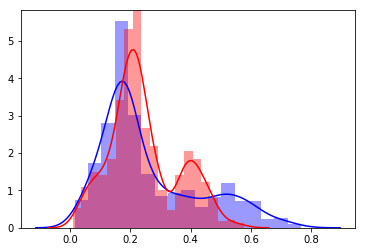

In [21]:
#compare predict probas
probas = latest_model.predict_proba(test_x)
dem_probs = []
rep_probs = []
for i in range(len(probas)):
    rep_probs.append(probas[i][1])
    dem_probs.append(probas[i][2])
print('    average dem score: ', sum(dem_probs) / len(dem_probs))
print('    average rep score: ', sum(rep_probs) / len(rep_probs))
#Distribution of republican and Democrat strength scoring
sns.distplot(dem_probs, label='dem', color='blue') 
sns.distplot(rep_probs, label='rep', color='red')

In [43]:
'''
Interpretation: Republicans talk about fewer things, but those things are big indicators. Maybe it takes a higher number of keywords to trigger Dem prediction?
For the purposes of applying this to a random subreddit, 
we want scores outside [.38 to .62], to be safe'''

'\nInterpretation: Republicans talk about fewer things, but those things are big indicators. Maybe it takes a higher number of keywords to trigger Dem prediction?\nFor the purposes of applying this to a random subreddit, \nwe want scores outside [.38 to .62], to be safe'

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


   net:  -16.038484360109646
   mean:  -0.020023076604381577
   med:  0.012892502006608852
   mode:  ModeResult(mode=array([0.03668148]), count=array([25]))


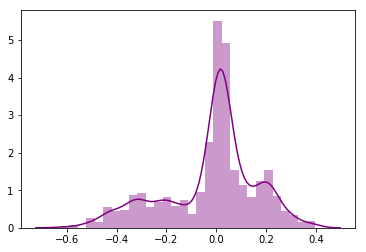

In [22]:
probas = latest_model.predict_proba(test_x)
net_probs = []
for i in range(len(probas)):
    net_probs.append(probas[i][1] - probas[i][2]) #R minus D so that Republican == positive, 

sns.distplot(net_probs, label='rep', color='purple')
print('   net: ', sum(net_probs))
print('   mean: ', np.average(net_probs))
print('   med: ', np.median(net_probs))
print('   mode: ', sp.stats.mode(net_probs))

In [38]:
test_y[:10]

682     2
2771    0
2073    0
1163    1
3731    0
3598    0
2974    0
3198    0
2704    0
1947    1
Name: subred_cat, dtype: int32

In [39]:
latest_model.predict_proba(test_x)[:10]

array([[0.28148128, 0.22647896, 0.49203975],
       [0.82253709, 0.09586105, 0.08160185],
       [0.56017171, 0.22971746, 0.21011083],
       [0.51359402, 0.35802076, 0.12838522],
       [0.57029391, 0.23319379, 0.1965123 ],
       [0.78168082, 0.11254381, 0.10577537],
       [0.76108442, 0.09817446, 0.14074112],
       [0.95096032, 0.02006578, 0.0289739 ],
       [0.50651588, 0.24228378, 0.25120034],
       [0.50478231, 0.23113484, 0.26408286]])

In [43]:

latest_model.predict_proba(test_x).shape
test_y.shape

(801,)

In [ ]:
'''WHY IS THE LAST ONE PREDICTING REPUBLICAN IF THE PROBABILITY IS LOWER?????'''

### Which posts were the most?

In [23]:
df_checker = pd.DataFrame(pd.Series(test_y))

In [24]:
df_checker['rep_score'] = [probas[i][1] for i in range(len(probas))]
df_checker['dem_score'] = [probas[i][2] for i in range(len(probas))]

In [25]:
#Most republican post
df_checker[df_checker['rep_score']==df_checker['rep_score'].max()]

,subred_cat,rep_score,dem_score
1788,1,0.577256,0.218682
1261,1,0.577256,0.218682


In [26]:
#Most democratic post
df_checker[df_checker['dem_score']==df_checker['dem_score'].max()]

,subred_cat,rep_score,dem_score
239,2,0.143783,0.76687


In [27]:
#The most democratic thing you could suggest right now:
#df_init_DemRep.iloc[96:97, :] no selftext...
df_init_DemRep['title'][239]

#After updates, still same post

'R.I.P. McCain'

In [28]:
#The most Republican thing you could suggest right now:
#df_init_DemRep.iloc[987:988, :]no selftext...
df_init_DemRep['title'][1261]

'GOP Congressional candidate Elizabeth Heng Gets Facebook Blocked'

In [29]:
df_init_DemRep['title'][1788] #REPOST

'GOP Congressional candidate Elizabeth Heng Gets Facebook Blocked'

# Outside Testing
---
Getting scores and validation from 3rd and 4th subreddit. 

## Outside Testing: All
Establishing a baseline for net scoring process

In [96]:
data_list = []
base_url = "https://www.reddit.com/r/all/.json"
URL = base_url
#seems to be a cap at 20
for step in range(20):
    res = requests.get(URL, headers={'User-agent': 'Conor Barry Bot 0.1'})
    data = res.json()
    
    for i in range(len(data['data']['children'])):
        temp = {}
        temp['subreddit'] = data['data']['children'][i]['data']['subreddit_name_prefixed'].replace('r/', '')
        temp['title']=data['data']['children'][i]['data']['title']
        temp['selftext'] = data['data']['children'][i]['data']['selftext']
        data_list.append(temp)

    new_after = data['data']['after']
    URL = base_url + "?after=" + new_after
    print('    iteration {} worked. URL: {}'.format(step, URL))
    time.sleep(3)
    
df_all_scrape = pd.DataFrame(data_list)
print('    size: ', df_hbb_scrape.shape)
# Export to csv
df_all_scrape.to_csv('./Data/allPosts_9_04_A.csv', index=False)
df_all_scrape.head()

    iteration 0 worked. URL: https://www.reddit.com/r/all/.json?after=t3_9cu3jb
    iteration 1 worked. URL: https://www.reddit.com/r/all/.json?after=t3_9cv3fp
    iteration 2 worked. URL: https://www.reddit.com/r/all/.json?after=t3_9cuubb
    iteration 3 worked. URL: https://www.reddit.com/r/all/.json?after=t3_9cuoyl
    iteration 4 worked. URL: https://www.reddit.com/r/all/.json?after=t3_9cttk3
    iteration 5 worked. URL: https://www.reddit.com/r/all/.json?after=t3_9crpsw
    iteration 6 worked. URL: https://www.reddit.com/r/all/.json?after=t3_9cuywt
    iteration 7 worked. URL: https://www.reddit.com/r/all/.json?after=t3_9cvhpa
    iteration 8 worked. URL: https://www.reddit.com/r/all/.json?after=t3_9cu5ii
    iteration 9 worked. URL: https://www.reddit.com/r/all/.json?after=t3_9cuzql
    iteration 10 worked. URL: https://www.reddit.com/r/all/.json?after=t3_9cvsdo
    iteration 11 worked. URL: https://www.reddit.com/r/all/.json?after=t3_9ctxog
    iteration 12 worked. URL: https://

,selftext,subreddit,title
0,,comics,Immortality
1,,sports,Sidecar co-pilots hugging the corners at the S...
2,,worldnews,The EU and national funders launch a plan to m...
3,,pics,My Grandpa turned 100 last week. He stayed up ...
4,,coolguides,"And this folks, is how gerrymandering works"


In [102]:
#Jump into analysis for this subreddit here from here
df_data_current = pd.read_csv('./Data/allPosts_9_04_A.csv').loc[:, ['title']]
X_cur = latest_transform.transform(df_data_current.title).todense()
df_cur_predictions = pd.DataFrame(latest_model.predict(X_cur),
                                 columns=['Party'])

df_cur_predictions = df_cur_predictions.join(pd.DataFrame(latest_model.predict_proba(X_cur), columns = ['none_score','rep_score', 'dem_score'] ))

'''The next 3 rows mimic the output of a 2 category model with type republican =0, democrat=1. 
Since we are asking, what is the dominant party ranking for this sub, other than none, we want some intentionally biased results.'''
df_cur_predictions['NewDem'] = 1*(df_cur_predictions['dem_score'] > df_cur_predictions['rep_score']) #Score whichever is higher proba
#create 'Normalized' probabs based on the assumption that a post is either republican or democrat and never neither 
df_cur_predictions['NewDem_proba'] = df_cur_predictions['dem_score']/(df_cur_predictions['dem_score']+df_cur_predictions['rep_score'])
df_cur_predictions['NewRep_proba'] = 1 - df_cur_predictions['NewDem_proba']

#Counts
print('   None: ', len(df_cur_predictions[df_cur_predictions.Party == 0]))
print('   Rep: ', len(df_cur_predictions[df_cur_predictions.Party == 1]))
print('   Dem: ', len(df_cur_predictions[df_cur_predictions.Party == 2]))
#Average party rating across all posts
print('   Adj Dem Count: ', df_cur_predictions['NewDem'].sum())
print('   Adj Rep Count: ', df_cur_predictions['NewDem'].count() - df_cur_predictions['NewDem'].sum())
#Avg aggregate rating - >.5 indicates dem
print('   Net: ', df_cur_predictions['NewDem'].mean())

#summarize winning scores for each party 
probas = df_cur_predictions.loc[:, ['NewDem_proba', 'NewRep_proba']]
min_prob = .5
dem_probs = []
rep_probs = []
for i in range(len(probas)):
    if probas.iloc[i][1] >min_prob:
        rep_probs.append(probas.iloc[i][1])
    elif probas.iloc[i][0]>min_prob:
        dem_probs.append(probas.iloc[i][0])
print('   average dem score: ', sum(dem_probs) / len(dem_probs))
print('   average rep score: ', sum(rep_probs) / len(rep_probs))
#More republican or more dem scores?
print('   net score: ', len(rep_probs) - len(dem_probs)) 

   None:  494
   Rep:  2
   Dem:  4
   Adj Dem Count:  78
   Adj Rep Count:  422
   Net:  0.156
   average dem score:  0.5515542765117288
   average rep score:  0.544843469816542
   net score:  344


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


   net:  29.80542138933171
   mean:  0.05961084277866336
   mode:  ModeResult(mode=array([0.07705703]), count=array([26]))
   med:  0.07631344869253698


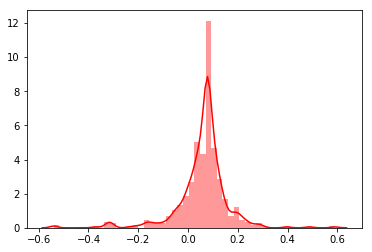

In [73]:
net_probs = []
for i in range(len(probas)):
    net_probs.append(probas.iloc[i][1] - probas.iloc[i][0]) #R minus D so that Republican == positive, 

sns.distplot(net_probs, label='rep', color='red')
print('   net: ', sum(net_probs))
print('   mean: ', np.average(net_probs))
print('   mode: ', sp.stats.mode(net_probs))
print('   med: ', np.median(net_probs))
plt.savefig('./Presentation/OutputFigs/AllNet_3.png')

In [51]:
from scipy.stats import ttest_1samp

## Outside Testing: The_Donald


In [132]:
data_list = []
base_url = "https://www.reddit.com/r/The_Donald/.json"
URL = base_url
#seems to be a cap at 20
for step in range(20):
    res = requests.get(URL, headers={'User-agent': 'Conor Barry Bot 0.1'})
    data = res.json()
    
    for i in range(len(data['data']['children'])):
        temp = {}
        temp['subreddit'] = data['data']['children'][i]['data']['subreddit_name_prefixed'].replace('r/', '')
        temp['title']=data['data']['children'][i]['data']['title']
        temp['selftext'] = data['data']['children'][i]['data']['selftext']
        data_list.append(temp)

    new_after = data['data']['after']
    URL = base_url + "?after=" + new_after
    print('    iteration {} worked. URL: {}'.format(step, URL))
    time.sleep(3)
    
df_donald_scrape = pd.DataFrame(data_list)
print('    size: ', df_donald_scrape.shape)
# Export to csv
df_donald_scrape.to_csv('./Data/TheDonaldPosts_9_03_A.csv', index=False)
df_donald_scrape.head()

    iteration 0 worked. URL: https://www.reddit.com/r/The_Donald/.json?after=t3_9coezc
    iteration 1 worked. URL: https://www.reddit.com/r/The_Donald/.json?after=t3_9cly58
    iteration 2 worked. URL: https://www.reddit.com/r/The_Donald/.json?after=t3_9cmdzg
    iteration 3 worked. URL: https://www.reddit.com/r/The_Donald/.json?after=t3_9cpm1d
    iteration 4 worked. URL: https://www.reddit.com/r/The_Donald/.json?after=t3_9cpbu3
    iteration 5 worked. URL: https://www.reddit.com/r/The_Donald/.json?after=t3_9ckq7m
    iteration 6 worked. URL: https://www.reddit.com/r/The_Donald/.json?after=t3_9cpqvs
    iteration 7 worked. URL: https://www.reddit.com/r/The_Donald/.json?after=t3_9clac8
    iteration 8 worked. URL: https://www.reddit.com/r/The_Donald/.json?after=t3_9cgzae
    iteration 9 worked. URL: https://www.reddit.com/r/The_Donald/.json?after=t3_9coctc
    iteration 10 worked. URL: https://www.reddit.com/r/The_Donald/.json?after=t3_9cnzb3
    iteration 11 worked. URL: https://www.

,selftext,subreddit,title
0,,The_Donald,GEOTUS calls out President Bashar Al-Assad of ...
1,,The_Donald,Afghan asylum seeker is jailed for eight years...
2,,The_Donald,"I see that John Kerry, the father of the now t..."
3,,The_Donald,He could have kept to his billionaire lifestyl...
4,,The_Donald,Blue Wave 2018- Ben Garrison cartoon! Beach Cl...


In [101]:
#Jump into analysis for this subreddit here from here
df_data_current = pd.read_csv('./Data/TheDonaldPosts_9_03_A.csv').loc[:, ['title']]
X_cur = latest_transform.transform(df_data_current.title).todense()
df_cur_predictions = pd.DataFrame(latest_model.predict(X_cur),
                                 columns=['Party'])

df_cur_predictions = df_cur_predictions.join(pd.DataFrame(latest_model.predict_proba(X_cur), columns = ['none_score','rep_score', 'dem_score'] ))

'''The next 3 rows mimic the output of a 2 category model with type republican =0, democrat=1. 
Since we are asking, what is the dominant party ranking for this sub, other than none, we want some intentionally biased results.'''
df_cur_predictions['NewDem'] = 1*(df_cur_predictions['dem_score'] > df_cur_predictions['rep_score']) #Score whichever is higher proba
#create 'Normalized' probabs based on the assumption that a post is either republican or democrat and never neither 
df_cur_predictions['NewDem_proba'] = df_cur_predictions['dem_score']/(df_cur_predictions['dem_score']+df_cur_predictions['rep_score'])
df_cur_predictions['NewRep_proba'] = 1 - df_cur_predictions['NewDem_proba']

#Counts
print('   None: ', len(df_cur_predictions[df_cur_predictions.Party == 0]))
print('   Rep: ', len(df_cur_predictions[df_cur_predictions.Party == 1]))
print('   Dem: ', len(df_cur_predictions[df_cur_predictions.Party == 2]))
#Average party rating across all posts
print('   Adj Dem Count: ', df_cur_predictions['NewDem'].sum())
print('   Adj Rep Count: ', df_cur_predictions['NewDem'].count() - df_cur_predictions['NewDem'].sum())
#Avg aggregate rating - >.5 indicates dem
print('   Net: ', df_cur_predictions['NewDem'].mean())

#summarize winning scores for each party 
probas = df_cur_predictions.loc[:, ['NewDem_proba', 'NewRep_proba']]
min_prob = .5
dem_probs = []
rep_probs = []
for i in range(len(probas)):
    if probas.iloc[i][1] >min_prob:
        rep_probs.append(probas.iloc[i][1])
    elif probas.iloc[i][0]>min_prob:
        dem_probs.append(probas.iloc[i][0])
print('   average dem score: ', sum(dem_probs) / len(dem_probs))
print('   average rep score: ', sum(rep_probs) / len(rep_probs))
#More republican or more dem scores?
print('   net score: ', len(rep_probs) - len(dem_probs)) 

   None:  389
   Rep:  18
   Dem:  95
   Adj Dem Count:  256
   Adj Rep Count:  246
   Net:  0.5099601593625498
   average dem score:  0.6057296590470876
   average rep score:  0.5700230146387345
   net score:  -10


   net:  -19.68226222985171
   mean:  -0.03920769368496362
   mode:  ModeResult(mode=array([0.08536413]), count=array([18]))
   med:  -0.0022542729172194687


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


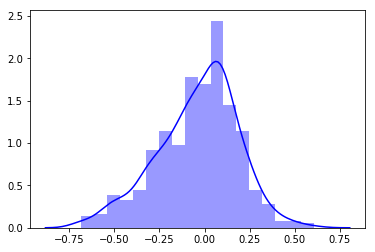

In [41]:
net_probs = []
for i in range(len(probas)):
    net_probs.append(probas.iloc[i][1] - probas.iloc[i][0]) #R minus D so that Republican == positive i.e. right side, 

sns.distplot(net_probs, label='rep', color='blue')
print('   net: ', sum(net_probs))
print('   mean: ', np.average(net_probs))
print('   mode: ', sp.stats.mode(net_probs))
print('   med: ', np.median(net_probs))
plt.savefig('./Presentation/OutputFigs/DonaldNet_3.png')

## Outside Testing: cats


In [193]:
data_list = []
base_url = "https://www.reddit.com/r/cats/.json"
URL = base_url
#seems to be a cap at 20
for step in range(20):
    res = requests.get(URL, headers={'User-agent': 'Conor Barry Bot 0.1'})
    data = res.json()
    
    for i in range(len(data['data']['children'])):
        temp = {}
        temp['subreddit'] = data['data']['children'][i]['data']['subreddit_name_prefixed'].replace('r/', '')
        temp['title']=data['data']['children'][i]['data']['title']
        temp['selftext'] = data['data']['children'][i]['data']['selftext']
        data_list.append(temp)

    new_after = data['data']['after']
    URL = base_url + "?after=" + new_after
    print('    iteration {} worked. URL: {}'.format(step, URL))
    time.sleep(3)
    
df_cats_scrape = pd.DataFrame(data_list)
print('    size: ', df_cats_scrape.shape)
# Export to csv
df_cats_scrape.to_csv('./Data/catsPosts_9_03_A.csv', index=False)
df_cats_scrape.head()

    iteration 0 worked. URL: https://www.reddit.com/r/cats/.json?after=t3_9cn1v8
    iteration 1 worked. URL: https://www.reddit.com/r/cats/.json?after=t3_9cn8tt
    iteration 2 worked. URL: https://www.reddit.com/r/cats/.json?after=t3_9couf1
    iteration 3 worked. URL: https://www.reddit.com/r/cats/.json?after=t3_9ckwel
    iteration 4 worked. URL: https://www.reddit.com/r/cats/.json?after=t3_9cq5p6
    iteration 5 worked. URL: https://www.reddit.com/r/cats/.json?after=t3_9cpxx4
    iteration 6 worked. URL: https://www.reddit.com/r/cats/.json?after=t3_9cmraq
    iteration 7 worked. URL: https://www.reddit.com/r/cats/.json?after=t3_9cmu8z
    iteration 8 worked. URL: https://www.reddit.com/r/cats/.json?after=t3_9cpozs
    iteration 9 worked. URL: https://www.reddit.com/r/cats/.json?after=t3_9clleo
    iteration 10 worked. URL: https://www.reddit.com/r/cats/.json?after=t3_9cpfky
    iteration 11 worked. URL: https://www.reddit.com/r/cats/.json?after=t3_9cn3e8
    iteration 12 worked. U

,selftext,subreddit,title
0,,cats,We got Ruth from a rescue centre. She follows ...
1,,cats,"She’s been gone four months, but I still miss ..."
2,,cats,"After a long battle with kidney disease, Squea..."
3,,cats,16 Year Old Bookmark
4,,cats,"He hates being held, but today he actually cli..."


In [100]:
#Jump into analysis for this subreddit here from here
df_data_current = pd.read_csv('./Data/catsPosts_9_03_A.csv').loc[:, ['title']]
X_cur = latest_transform.transform(df_data_current.title).todense()
df_cur_predictions = pd.DataFrame(latest_model.predict(X_cur),
                                 columns=['Party'])

df_cur_predictions = df_cur_predictions.join(pd.DataFrame(latest_model.predict_proba(X_cur), columns = ['none_score','rep_score', 'dem_score'] ))

'''The next 3 rows mimic the output of a 2 category model with type republican =0, democrat=1. 
Since we are asking, what is the dominant party ranking for this sub, other than none, we want some intentionally biased results.'''
df_cur_predictions['NewDem'] = 1*(df_cur_predictions['dem_score'] > df_cur_predictions['rep_score']) #Score whichever is higher proba
#create 'Normalized' probabs based on the assumption that a post is either republican or democrat and never neither 
df_cur_predictions['NewDem_proba'] = df_cur_predictions['dem_score']/(df_cur_predictions['dem_score']+df_cur_predictions['rep_score'])
df_cur_predictions['NewRep_proba'] = 1 - df_cur_predictions['NewDem_proba']

#Counts
print('   None: ', len(df_cur_predictions[df_cur_predictions.Party == 0]))
print('   Rep: ', len(df_cur_predictions[df_cur_predictions.Party == 1]))
print('   Dem: ', len(df_cur_predictions[df_cur_predictions.Party == 2]))
#Average party rating across all posts
print('   Adj Dem Count: ', df_cur_predictions['NewDem'].sum())
print('   Adj Rep Count: ', df_cur_predictions['NewDem'].count() - df_cur_predictions['NewDem'].sum())
#Avg aggregate rating - >.5 indicates dem
print('   Net: ', df_cur_predictions['NewDem'].mean())

#summarize winning scores for each party 
probas = df_cur_predictions.loc[:, ['NewDem_proba', 'NewRep_proba']]
min_prob = .5
dem_probs = []
rep_probs = []
for i in range(len(probas)):
    if probas.iloc[i][1] >min_prob:
        rep_probs.append(probas.iloc[i][1])
    elif probas.iloc[i][0]>min_prob:
        dem_probs.append(probas.iloc[i][0])
print('   average dem score: ', sum(dem_probs) / len(dem_probs))
print('   average rep score: ', sum(rep_probs) / len(rep_probs))
#More republican or more dem scores?
print('   net score: ', len(rep_probs) - len(dem_probs)) 

   None:  500
   Rep:  0
   Dem:  0
   Adj Dem Count:  91
   Adj Rep Count:  409
   Net:  0.182
   average dem score:  0.5321861761356134
   average rep score:  0.5385874544488888
   net score:  318


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


   net:  25.706653682509586
   mean:  0.05141330736501914
   mode:  ModeResult(mode=array([0.07705703]), count=array([15]))
   med:  0.06274179808083943


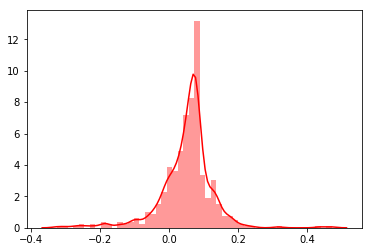

In [65]:
net_probs = []
for i in range(len(probas)):
    net_probs.append(probas.iloc[i][1] - probas.iloc[i][0]) #R minus D so that Republican == positive, 

sns.distplot(net_probs, label='rep', color='red')
print('   net: ', sum(net_probs))
print('   mean: ', np.average(net_probs))
print('   mode: ', sp.stats.mode(net_probs))
print('   med: ', np.median(net_probs))
plt.savefig('./Presentation/OutputFigs/catNet_3.png')

## Outside Testing: dogs


In [198]:
data_list = []
base_url = "https://www.reddit.com/r/dogs/.json"
URL = base_url
#seems to be a cap at 20
for step in range(20):
    res = requests.get(URL, headers={'User-agent': 'Conor Barry Bot 0.1'})
    data = res.json()
    
    for i in range(len(data['data']['children'])):
        temp = {}
        temp['subreddit'] = data['data']['children'][i]['data']['subreddit_name_prefixed'].replace('r/', '')
        temp['title']=data['data']['children'][i]['data']['title']
        temp['selftext'] = data['data']['children'][i]['data']['selftext']
        data_list.append(temp)

    new_after = data['data']['after']
    URL = base_url + "?after=" + new_after
    print('    iteration {} worked. URL: {}'.format(step, URL))
    time.sleep(3)
    
df_dogs_scrape = pd.DataFrame(data_list)
print('    size: ', df_dogs_scrape.shape)
# Export to csv
df_dogs_scrape.to_csv('./Data/dogsPosts_9_03_A.csv', index=False)
df_dogs_scrape.head()

    iteration 0 worked. URL: https://www.reddit.com/r/dogs/.json?after=t3_9cq4rj
    iteration 1 worked. URL: https://www.reddit.com/r/dogs/.json?after=t3_9cdkbj
    iteration 2 worked. URL: https://www.reddit.com/r/dogs/.json?after=t3_9ch3f8
    iteration 3 worked. URL: https://www.reddit.com/r/dogs/.json?after=t3_9cdqv8
    iteration 4 worked. URL: https://www.reddit.com/r/dogs/.json?after=t3_9cc9xc
    iteration 5 worked. URL: https://www.reddit.com/r/dogs/.json?after=t3_9c79yo
    iteration 6 worked. URL: https://www.reddit.com/r/dogs/.json?after=t3_9c7y7z
    iteration 7 worked. URL: https://www.reddit.com/r/dogs/.json?after=t3_9c35rl
    iteration 8 worked. URL: https://www.reddit.com/r/dogs/.json?after=t3_9btyjs
    iteration 9 worked. URL: https://www.reddit.com/r/dogs/.json?after=t3_9c01fp
    iteration 10 worked. URL: https://www.reddit.com/r/dogs/.json?after=t3_9bqjzl
    iteration 11 worked. URL: https://www.reddit.com/r/dogs/.json?after=t3_9bqj4z
    iteration 12 worked. U

,selftext,subreddit,title
0,"Dogs working because they love us, because we ...",dogs,[Photo Friday] A Labor of Love
1,"For the September Trick of the Month, we’ll be...",dogs,[Discussion] Trick of the Month - September 20...
2,"Ok, she's actually a great dog; troublemaker m...",dogs,[Fluff] My energetic troublemaker made me prou...
3,I was told he's a Pitt/Lab mix and he looks li...,dogs,[FLUFF] Every time someone asks what breed my ...
4,I came to his subreddit asking to learn about ...,dogs,[Discussion] Sometimes you do everything “righ...


In [99]:
#Jump into analysis for this subreddit here from here
df_data_current = pd.read_csv('./Data/dogsPosts_9_03_A.csv').loc[:, ['title']]
X_cur = latest_transform.transform(df_data_current.title).todense()
df_cur_predictions = pd.DataFrame(latest_model.predict(X_cur),
                                 columns=['Party'])

df_cur_predictions = df_cur_predictions.join(pd.DataFrame(latest_model.predict_proba(X_cur), columns = ['none_score','rep_score', 'dem_score'] ))

'''The next 3 rows mimic the output of a 2 category model with type republican =0, democrat=1. 
Since we are asking, what is the dominant party ranking for this sub, other than none, we want some intentionally biased results.'''
df_cur_predictions['NewDem'] = 1*(df_cur_predictions['dem_score'] > df_cur_predictions['rep_score']) #Score whichever is higher proba
#create 'Normalized' probabs based on the assumption that a post is either republican or democrat and never neither 
df_cur_predictions['NewDem_proba'] = df_cur_predictions['dem_score']/(df_cur_predictions['dem_score']+df_cur_predictions['rep_score'])
df_cur_predictions['NewRep_proba'] = 1 - df_cur_predictions['NewDem_proba']

#Counts
print('   None: ', len(df_cur_predictions[df_cur_predictions.Party == 0]))
print('   Rep: ', len(df_cur_predictions[df_cur_predictions.Party == 1]))
print('   Dem: ', len(df_cur_predictions[df_cur_predictions.Party == 2]))
#Average party rating across all posts
print('   Adj Dem Count: ', df_cur_predictions['NewDem'].sum())
print('   Adj Rep Count: ', df_cur_predictions['NewDem'].count() - df_cur_predictions['NewDem'].sum())
#Avg aggregate rating - >.5 indicates dem
print('   Net: ', df_cur_predictions['NewDem'].mean())

#summarize winning scores for each party 
probas = df_cur_predictions.loc[:, ['NewDem_proba', 'NewRep_proba']]
min_prob = .5
dem_probs = []
rep_probs = []
for i in range(len(probas)):
    if probas.iloc[i][1] >min_prob:
        rep_probs.append(probas.iloc[i][1])
    elif probas.iloc[i][0]>min_prob:
        dem_probs.append(probas.iloc[i][0])
print('   average dem score: ', sum(dem_probs) / len(dem_probs))
print('   average rep score: ', sum(rep_probs) / len(rep_probs))
#More republican or more dem scores?
print('   net score: ', len(rep_probs) - len(dem_probs)) 

   None:  502
   Rep:  0
   Dem:  0
   Adj Dem Count:  158
   Adj Rep Count:  344
   Net:  0.3147410358565737
   average dem score:  0.5294671606480233
   average rep score:  0.5291590798008703
   net score:  186


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


   net:  10.749824138223211
   mean:  0.02141399230721754
   mode:  ModeResult(mode=array([-0.14737861]), count=array([3]))
   med:  0.032421128053753745


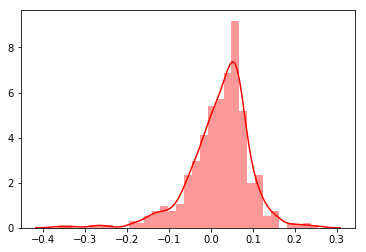

In [67]:
net_probs = []
for i in range(len(probas)):
    net_probs.append(probas.iloc[i][1] - probas.iloc[i][0]) #R minus D so that Republican == positive, 

sns.distplot(net_probs, label='rep', color='red')
print('   net: ', sum(net_probs))
print('   mean: ', np.average(net_probs))
print('   mode: ', sp.stats.mode(net_probs))
print('   med: ', np.median(net_probs))
plt.savefig('./Presentation/OutputFigs/dogNet_3.png')

## Outside Testing: Communism


In [76]:
data_list = []
base_url = "https://www.reddit.com/r/communism/.json"
URL = base_url
#seems to be a cap at 20
for step in range(20):
    res = requests.get(URL, headers={'User-agent': 'Conor Barry Bot 0.1'})
    data = res.json()
    
    for i in range(len(data['data']['children'])):
        temp = {}
        temp['subreddit'] = data['data']['children'][i]['data']['subreddit_name_prefixed'].replace('r/', '')
        temp['title']=data['data']['children'][i]['data']['title']
        temp['selftext'] = data['data']['children'][i]['data']['selftext']
        data_list.append(temp)

    new_after = data['data']['after']
    URL = base_url + "?after=" + new_after
    print('    iteration {} worked. URL: {}'.format(step, URL))
    time.sleep(3)
    
df_communism_scrape = pd.DataFrame(data_list)
print('    size: ', df_communism_scrape.shape)
# Export to csv
df_communism_scrape.to_csv('./Data/communismPosts_9_03_A.csv', index=False)
df_communism_scrape.head()

    iteration 0 worked. URL: https://www.reddit.com/r/communism/.json?after=t3_9cmxzc
    iteration 1 worked. URL: https://www.reddit.com/r/communism/.json?after=t3_9c5a7b
    iteration 2 worked. URL: https://www.reddit.com/r/communism/.json?after=t3_9b75ta
    iteration 3 worked. URL: https://www.reddit.com/r/communism/.json?after=t3_9acj1g
    iteration 4 worked. URL: https://www.reddit.com/r/communism/.json?after=t3_99mbnz
    iteration 5 worked. URL: https://www.reddit.com/r/communism/.json?after=t3_98xa0s
    iteration 6 worked. URL: https://www.reddit.com/r/communism/.json?after=t3_980lcj
    iteration 7 worked. URL: https://www.reddit.com/r/communism/.json?after=t3_976vbj
    iteration 8 worked. URL: https://www.reddit.com/r/communism/.json?after=t3_96ik3a
    iteration 9 worked. URL: https://www.reddit.com/r/communism/.json?after=t3_95zgjx
    iteration 10 worked. URL: https://www.reddit.com/r/communism/.json?after=t3_95dr7f
    iteration 11 worked. URL: https://www.reddit.com/

,selftext,subreddit,title
0,,communism,Transcript of Xi Jinping's keynote speech at t...
1,"Hey comrades, I went looking for the website f...",communism,Pravda media website gone?
2,,communism,China announces huge debt relief program for c...
3,i've struggled with intense physical and menta...,communism,disabled comrades?
4,,communism,2018 Main Political Report — Resolution on the...


In [97]:
#Jump into analysis for this subreddit here from here
df_data_current = pd.read_csv('./Data/communismPosts_9_04_A.csv').loc[:, ['title']]
X_cur = latest_transform.transform(df_data_current.title).todense()
df_cur_predictions = pd.DataFrame(latest_model.predict(X_cur),
                                 columns=['Party'])

df_cur_predictions = df_cur_predictions.join(pd.DataFrame(latest_model.predict_proba(X_cur), columns = ['none_score','rep_score', 'dem_score'] ))

'''The next 3 rows mimic the output of a 2 category model with type republican =0, democrat=1. 
Since we are asking, what is the dominant party ranking for this sub, other than none, we want some intentionally biased results.'''
df_cur_predictions['NewDem'] = 1*(df_cur_predictions['dem_score'] > df_cur_predictions['rep_score']) #Score whichever is higher proba
#create 'Normalized' probabs based on the assumption that a post is either republican or democrat and never neither 
df_cur_predictions['NewDem_proba'] = df_cur_predictions['dem_score']/(df_cur_predictions['dem_score']+df_cur_predictions['rep_score'])
df_cur_predictions['NewRep_proba'] = 1 - df_cur_predictions['NewDem_proba']

#Counts
print('   None: ', len(df_cur_predictions[df_cur_predictions.Party == 0]))
print('   Rep: ', len(df_cur_predictions[df_cur_predictions.Party == 1]))
print('   Dem: ', len(df_cur_predictions[df_cur_predictions.Party == 2]))
#Average party rating across all posts
print('   Adj Dem Count: ', df_cur_predictions['NewDem'].sum())
print('   Adj Rep Count: ', df_cur_predictions['NewDem'].count() - df_cur_predictions['NewDem'].sum())
#Avg aggregate rating - >.5 indicates dem
print('   Net: ', df_cur_predictions['NewDem'].mean())

#summarize winning scores for each party 
probas = df_cur_predictions.loc[:, ['NewDem_proba', 'NewRep_proba']]
min_prob = .5
dem_probs = []
rep_probs = []
for i in range(len(probas)):
    if probas.iloc[i][1] >min_prob:
        rep_probs.append(probas.iloc[i][1])
    elif probas.iloc[i][0]>min_prob:
        dem_probs.append(probas.iloc[i][0])
print('   average dem score: ', sum(dem_probs) / len(dem_probs))
print('   average rep score: ', sum(rep_probs) / len(rep_probs))
#More republican or more dem scores?
print('   net score: ', len(rep_probs) - len(dem_probs)) 

   None:  447
   Rep:  31
   Dem:  22
   Adj Dem Count:  158
   Adj Rep Count:  342
   Net:  0.316
   average dem score:  0.5617698615694671
   average rep score:  0.5803258226720289
   net score:  184


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


   net:  35.42358645171613
   mean:  0.07084717290343236
   mode:  ModeResult(mode=array([0.08536413]), count=array([23]))
   med:  0.08346670345619911


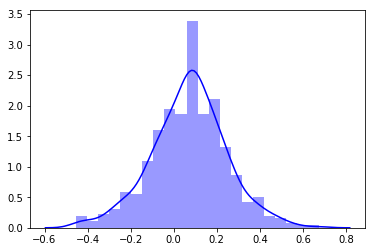

In [98]:
net_probs = []
for i in range(len(probas)):
    net_probs.append(probas.iloc[i][1] - probas.iloc[i][0]) #R minus D so that Republican == positive, 

sns.distplot(net_probs, label='rep', color='blue')
print('   net: ', sum(net_probs))
print('   mean: ', np.average(net_probs))
print('   mode: ', sp.stats.mode(net_probs))
print('   med: ', np.median(net_probs))
plt.savefig('./Presentation/OutputFigs/communismNet_3.png')

## Outside Testing: libertarian


In [77]:
data_list = []
base_url = "https://www.reddit.com/r/Libertarian/.json"
URL = base_url
#seems to be a cap at 20
for step in range(20):
    res = requests.get(URL, headers={'User-agent': 'Conor Barry Bot 0.1'})
    data = res.json()
    
    for i in range(len(data['data']['children'])):
        temp = {}
        temp['subreddit'] = data['data']['children'][i]['data']['subreddit_name_prefixed'].replace('r/', '')
        temp['title']=data['data']['children'][i]['data']['title']
        temp['selftext'] = data['data']['children'][i]['data']['selftext']
        data_list.append(temp)

    new_after = data['data']['after']
    URL = base_url + "?after=" + new_after
    print('    iteration {} worked. URL: {}'.format(step, URL))
    time.sleep(3)
    
df_Libertarian_scrape = pd.DataFrame(data_list)
print('    size: ', df_Libertarian_scrape.shape)
# Export to csv
df_Libertarian_scrape.to_csv('./Data/LibertarianPosts_9_04_A.csv', index=False)
df_Libertarian_scrape.head()

    iteration 0 worked. URL: https://www.reddit.com/r/Libertarian/.json?after=t3_9cvuxa
    iteration 1 worked. URL: https://www.reddit.com/r/Libertarian/.json?after=t3_9cz6ha
    iteration 2 worked. URL: https://www.reddit.com/r/Libertarian/.json?after=t3_9cojaz
    iteration 3 worked. URL: https://www.reddit.com/r/Libertarian/.json?after=t3_9cvjiz
    iteration 4 worked. URL: https://www.reddit.com/r/Libertarian/.json?after=t3_9crdit
    iteration 5 worked. URL: https://www.reddit.com/r/Libertarian/.json?after=t3_9cwgp7
    iteration 6 worked. URL: https://www.reddit.com/r/Libertarian/.json?after=t3_9ct1je
    iteration 7 worked. URL: https://www.reddit.com/r/Libertarian/.json?after=t3_9cpsis
    iteration 8 worked. URL: https://www.reddit.com/r/Libertarian/.json?after=t3_9csh4o
    iteration 9 worked. URL: https://www.reddit.com/r/Libertarian/.json?after=t3_9cpk5c
    iteration 10 worked. URL: https://www.reddit.com/r/Libertarian/.json?after=t3_9crj86
    iteration 11 worked. URL: h

,selftext,subreddit,title
0,,Libertarian,/r/Libertarian wiki
1,,Libertarian,"AMA: ""What Is An Open-Source Legal System?"" wi..."
2,,Libertarian,School Choice
3,,Libertarian,Police officer gets taunted by guy she falsely...
4,,Libertarian,"Thank You, Garbage Collector Man."


In [95]:
#Jump into analysis for this subreddit here from here
df_data_current = pd.read_csv('./Data/LibertarianPosts_9_04_A.csv').loc[:, ['title']]
X_cur = latest_transform.transform(df_data_current.title).todense()
df_cur_predictions = pd.DataFrame(latest_model.predict(X_cur),
                                 columns=['Party'])

df_cur_predictions = df_cur_predictions.join(pd.DataFrame(latest_model.predict_proba(X_cur), columns = ['none_score','rep_score', 'dem_score'] ))

'''The next 3 rows mimic the output of a 2 category model with type republican =0, democrat=1. 
Since we are asking, what is the dominant party ranking for this sub, other than none, we want some intentionally biased results.'''
df_cur_predictions['NewDem'] = 1*(df_cur_predictions['dem_score'] > df_cur_predictions['rep_score']) #Score whichever is higher proba
#create 'Normalized' probabs based on the assumption that a post is either republican or democrat and never neither 
df_cur_predictions['NewDem_proba'] = df_cur_predictions['dem_score']/(df_cur_predictions['dem_score']+df_cur_predictions['rep_score'])
df_cur_predictions['NewRep_proba'] = 1 - df_cur_predictions['NewDem_proba']

#Counts
print('   None: ', len(df_cur_predictions[df_cur_predictions.Party == 0]))
print('   Rep: ', len(df_cur_predictions[df_cur_predictions.Party == 1]))
print('   Dem: ', len(df_cur_predictions[df_cur_predictions.Party == 2]))
#Average party rating across all posts
print('   Adj Dem Count: ', df_cur_predictions['NewDem'].sum())
print('   Adj Rep Count: ', df_cur_predictions['NewDem'].count() - df_cur_predictions['NewDem'].sum())
#Avg aggregate rating - >.5 indicates dem
print('   Net: ', df_cur_predictions['NewDem'].mean())

#summarize winning scores for each party 
probas = df_cur_predictions.loc[:, ['NewDem_proba', 'NewRep_proba']]
min_prob = .5
dem_probs = []
rep_probs = []
for i in range(len(probas)):
    if probas.iloc[i][1] >min_prob:
        rep_probs.append(probas.iloc[i][1])
    elif probas.iloc[i][0]>min_prob:
        dem_probs.append(probas.iloc[i][0])
print('   average dem score: ', sum(dem_probs) / len(dem_probs))
print('   average rep score: ', sum(rep_probs) / len(rep_probs))
#More republican or more dem scores?
print('   net score: ', len(rep_probs) - len(dem_probs)) 

   None:  420
   Rep:  35
   Dem:  47
   Adj Dem Count:  162
   Adj Rep Count:  340
   Net:  0.32270916334661354
   average dem score:  0.5810709181278519
   average rep score:  0.5820101703490144
   net score:  178


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


   net:  29.499938363905844
   mean:  0.05876481745797974
   mode:  ModeResult(mode=array([0.08536413]), count=array([30]))
   med:  0.07987649393662757


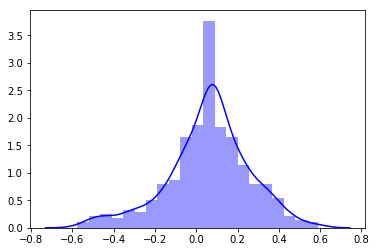

In [87]:
net_probs = []
for i in range(len(probas)):
    net_probs.append(probas.iloc[i][1] - probas.iloc[i][0]) #R minus D so that Republican == positive, 

sns.distplot(net_probs, label='rep', color='blue')
print('   net: ', sum(net_probs))
print('   mean: ', np.average(net_probs))
print('   mode: ', sp.stats.mode(net_probs))
print('   med: ', np.median(net_probs))
plt.savefig('./Presentation/OutputFigs/LibertarianNet_3.png')

## Outside Testing: Liberal/


In [103]:
data_list = []
base_url = "https://www.reddit.com/r/Liberal/.json"
URL = base_url
#seems to be a cap at 20
for step in range(20):
    res = requests.get(URL, headers={'User-agent': 'Conor Barry Bot 0.1'})
    data = res.json()
    
    for i in range(len(data['data']['children'])):
        temp = {}
        temp['subreddit'] = data['data']['children'][i]['data']['subreddit_name_prefixed'].replace('r/', '')
        temp['title']=data['data']['children'][i]['data']['title']
        temp['selftext'] = data['data']['children'][i]['data']['selftext']
        data_list.append(temp)

    new_after = data['data']['after']
    URL = base_url + "?after=" + new_after
    print('    iteration {} worked. URL: {}'.format(step, URL))
    time.sleep(3)
    
df_liberal_scrape = pd.DataFrame(data_list)
print('    size: ', df_liberal_scrape.shape)
# Export to csv
df_liberal_scrape.to_csv('./Data/liberalPosts_9_04_A.csv', index=False)
df_liberal_scrape.head()

    iteration 0 worked. URL: https://www.reddit.com/r/Liberal/.json?after=t3_9chirq
    iteration 1 worked. URL: https://www.reddit.com/r/Liberal/.json?after=t3_9b0axh
    iteration 2 worked. URL: https://www.reddit.com/r/Liberal/.json?after=t3_9abj8h
    iteration 3 worked. URL: https://www.reddit.com/r/Liberal/.json?after=t3_99f6wa
    iteration 4 worked. URL: https://www.reddit.com/r/Liberal/.json?after=t3_98msts
    iteration 5 worked. URL: https://www.reddit.com/r/Liberal/.json?after=t3_97lf96
    iteration 6 worked. URL: https://www.reddit.com/r/Liberal/.json?after=t3_965or8
    iteration 7 worked. URL: https://www.reddit.com/r/Liberal/.json?after=t3_9562qz
    iteration 8 worked. URL: https://www.reddit.com/r/Liberal/.json?after=t3_94dck5
    iteration 9 worked. URL: https://www.reddit.com/r/Liberal/.json?after=t3_93nyz7
    iteration 10 worked. URL: https://www.reddit.com/r/Liberal/.json?after=t3_92eew1
    iteration 11 worked. URL: https://www.reddit.com/r/Liberal/.json?after=

,selftext,subreddit,title
0,,Liberal,Silencing athletes is a way of asserting that ...
1,,Liberal,Trump called Attorney Jeff Sessions a 'traitor...
2,,Liberal,My friend's baby girl died as a result of the ...
3,,Liberal,Kavanaugh hearings: Democrats want you to know...
4,,Liberal,Opinion | Does Brett Kavanaugh Spell the End o...


In [106]:
#Jump into analysis for this subreddit here from here
df_data_current = pd.read_csv('./Data/liberalPosts_9_04_A.csv').loc[:, ['title']]
X_cur = latest_transform.transform(df_data_current.title).todense()
df_cur_predictions = pd.DataFrame(latest_model.predict(X_cur),
                                 columns=['Party'])

df_cur_predictions = df_cur_predictions.join(pd.DataFrame(latest_model.predict_proba(X_cur), columns = ['none_score','rep_score', 'dem_score'] ))

'''The next 3 rows mimic the output of a 2 category model with type republican =0, democrat=1. 
Since we are asking, what is the dominant party ranking for this sub, other than none, we want some intentionally biased results.'''
df_cur_predictions['NewDem'] = 1*(df_cur_predictions['dem_score'] > df_cur_predictions['rep_score']) #Score whichever is higher proba
#create 'Normalized' probabs based on the assumption that a post is either republican or democrat and never neither 
df_cur_predictions['NewDem_proba'] = df_cur_predictions['dem_score']/(df_cur_predictions['dem_score']+df_cur_predictions['rep_score'])
df_cur_predictions['NewRep_proba'] = 1 - df_cur_predictions['NewDem_proba']

#Counts
print('   None: ', len(df_cur_predictions[df_cur_predictions.Party == 0]))
print('   Rep: ', len(df_cur_predictions[df_cur_predictions.Party == 1]))
print('   Dem: ', len(df_cur_predictions[df_cur_predictions.Party == 2]))
#Average party rating across all posts
print('   Adj Dem Count: ', df_cur_predictions['NewDem'].sum())
print('   Adj Rep Count: ', df_cur_predictions['NewDem'].count() - df_cur_predictions['NewDem'].sum())
#Avg aggregate rating - >.5 indicates dem
print('   Net: ', df_cur_predictions['NewDem'].mean())

#summarize winning scores for each party 
probas = df_cur_predictions.loc[:, ['NewDem_proba', 'NewRep_proba']]
min_prob = .5
dem_probs = []
rep_probs = []
for i in range(len(probas)):
    if probas.iloc[i][1] >min_prob:
        rep_probs.append(probas.iloc[i][1])
    elif probas.iloc[i][0]>min_prob:
        dem_probs.append(probas.iloc[i][0])
print('   average dem score: ', sum(dem_probs) / len(dem_probs))
print('   average rep score: ', sum(rep_probs) / len(rep_probs))
#More republican or more dem scores?
print('   net score: ', len(rep_probs) - len(dem_probs)) 

   None:  221
   Rep:  56
   Dem:  223
   Adj Dem Count:  301
   Adj Rep Count:  199
   Net:  0.602
   average dem score:  0.6320112384036628
   average rep score:  0.5889366173757657
   net score:  -102


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


   net:  -44.073991803450596
   mean:  -0.0881479836069011
   mode:  ModeResult(mode=array([0.08536413]), count=array([2]))
   med:  -0.07437071308243737


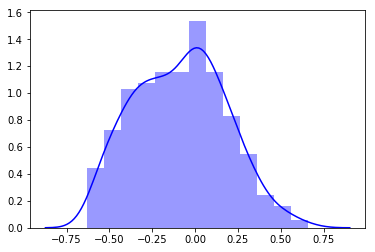

In [107]:
net_probs = []
for i in range(len(probas)):
    net_probs.append(probas.iloc[i][1] - probas.iloc[i][0]) #R minus D so that Republican == positive, 

sns.distplot(net_probs, label='rep', color='blue')
print('   net: ', sum(net_probs))
print('   mean: ', np.average(net_probs))
print('   mode: ', sp.stats.mode(net_probs))
print('   med: ', np.median(net_probs))
plt.savefig('./Presentation/OutputFigs/liberalNet_3.png')

## Outside Testing: Liberal/


In [103]:
data_list = []
base_url = "https://www.reddit.com/r/Liberal/.json"
URL = base_url
#seems to be a cap at 20
for step in range(20):
    res = requests.get(URL, headers={'User-agent': 'Conor Barry Bot 0.1'})
    data = res.json()
    
    for i in range(len(data['data']['children'])):
        temp = {}
        temp['subreddit'] = data['data']['children'][i]['data']['subreddit_name_prefixed'].replace('r/', '')
        temp['title']=data['data']['children'][i]['data']['title']
        temp['selftext'] = data['data']['children'][i]['data']['selftext']
        data_list.append(temp)

    new_after = data['data']['after']
    URL = base_url + "?after=" + new_after
    print('    iteration {} worked. URL: {}'.format(step, URL))
    time.sleep(3)
    
df_gameofthrones_scrape = pd.DataFrame(data_list)
print('    size: ', df_gameofthrones_scrape.shape)
# Export to csv
df_gameofthrones_scrape.to_csv('./Data/gameofthronesPosts_9_04_A.csv', index=False)
df_gameofthrones_scrape.head()

    iteration 0 worked. URL: https://www.reddit.com/r/Liberal/.json?after=t3_9chirq
    iteration 1 worked. URL: https://www.reddit.com/r/Liberal/.json?after=t3_9b0axh
    iteration 2 worked. URL: https://www.reddit.com/r/Liberal/.json?after=t3_9abj8h
    iteration 3 worked. URL: https://www.reddit.com/r/Liberal/.json?after=t3_99f6wa
    iteration 4 worked. URL: https://www.reddit.com/r/Liberal/.json?after=t3_98msts
    iteration 5 worked. URL: https://www.reddit.com/r/Liberal/.json?after=t3_97lf96
    iteration 6 worked. URL: https://www.reddit.com/r/Liberal/.json?after=t3_965or8
    iteration 7 worked. URL: https://www.reddit.com/r/Liberal/.json?after=t3_9562qz
    iteration 8 worked. URL: https://www.reddit.com/r/Liberal/.json?after=t3_94dck5
    iteration 9 worked. URL: https://www.reddit.com/r/Liberal/.json?after=t3_93nyz7
    iteration 10 worked. URL: https://www.reddit.com/r/Liberal/.json?after=t3_92eew1
    iteration 11 worked. URL: https://www.reddit.com/r/Liberal/.json?after=

,selftext,subreddit,title
0,,Liberal,Silencing athletes is a way of asserting that ...
1,,Liberal,Trump called Attorney Jeff Sessions a 'traitor...
2,,Liberal,My friend's baby girl died as a result of the ...
3,,Liberal,Kavanaugh hearings: Democrats want you to know...
4,,Liberal,Opinion | Does Brett Kavanaugh Spell the End o...


In [106]:
#Jump into analysis for this subreddit here from here
df_data_current = pd.read_csv('./Data/gameofthronesPosts_9_04_A.csv').loc[:, ['title']]
X_cur = latest_transform.transform(df_data_current.title).todense()
df_cur_predictions = pd.DataFrame(latest_model.predict(X_cur),
                                 columns=['Party'])

df_cur_predictions = df_cur_predictions.join(pd.DataFrame(latest_model.predict_proba(X_cur), columns = ['none_score','rep_score', 'dem_score'] ))

'''The next 3 rows mimic the output of a 2 category model with type republican =0, democrat=1. 
Since we are asking, what is the dominant party ranking for this sub, other than none, we want some intentionally biased results.'''
df_cur_predictions['NewDem'] = 1*(df_cur_predictions['dem_score'] > df_cur_predictions['rep_score']) #Score whichever is higher proba
#create 'Normalized' probabs based on the assumption that a post is either republican or democrat and never neither 
df_cur_predictions['NewDem_proba'] = df_cur_predictions['dem_score']/(df_cur_predictions['dem_score']+df_cur_predictions['rep_score'])
df_cur_predictions['NewRep_proba'] = 1 - df_cur_predictions['NewDem_proba']

#Counts
print('   None: ', len(df_cur_predictions[df_cur_predictions.Party == 0]))
print('   Rep: ', len(df_cur_predictions[df_cur_predictions.Party == 1]))
print('   Dem: ', len(df_cur_predictions[df_cur_predictions.Party == 2]))
#Average party rating across all posts
print('   Adj Dem Count: ', df_cur_predictions['NewDem'].sum())
print('   Adj Rep Count: ', df_cur_predictions['NewDem'].count() - df_cur_predictions['NewDem'].sum())
#Avg aggregate rating - >.5 indicates dem
print('   Net: ', df_cur_predictions['NewDem'].mean())

#summarize winning scores for each party 
probas = df_cur_predictions.loc[:, ['NewDem_proba', 'NewRep_proba']]
min_prob = .5
dem_probs = []
rep_probs = []
for i in range(len(probas)):
    if probas.iloc[i][1] >min_prob:
        rep_probs.append(probas.iloc[i][1])
    elif probas.iloc[i][0]>min_prob:
        dem_probs.append(probas.iloc[i][0])
print('   average dem score: ', sum(dem_probs) / len(dem_probs))
print('   average rep score: ', sum(rep_probs) / len(rep_probs))
#More republican or more dem scores?
print('   net score: ', len(rep_probs) - len(dem_probs)) 

   None:  221
   Rep:  56
   Dem:  223
   Adj Dem Count:  301
   Adj Rep Count:  199
   Net:  0.602
   average dem score:  0.6320112384036628
   average rep score:  0.5889366173757657
   net score:  -102


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


   net:  -44.073991803450596
   mean:  -0.0881479836069011
   mode:  ModeResult(mode=array([0.08536413]), count=array([2]))
   med:  -0.07437071308243737


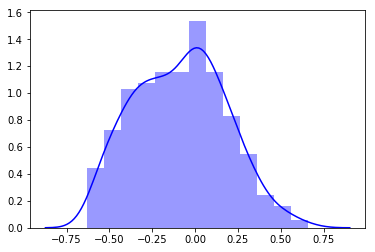

In [107]:
net_probs = []
for i in range(len(probas)):
    net_probs.append(probas.iloc[i][1] - probas.iloc[i][0]) #R minus D so that Republican == positive, 

sns.distplot(net_probs, label='rep', color='blue')
print('   net: ', sum(net_probs))
print('   mean: ', np.average(net_probs))
print('   mode: ', sp.stats.mode(net_probs))
print('   med: ', np.median(net_probs))
plt.savefig('./Presentation/OutputFigs/gameofthronesNet_3.png')

## Back Testing: Democrat


In [80]:
data_list = []
base_url = "https://www.reddit.com/r/democrats/.json"
URL = base_url
#seems to be a cap at 20
for step in range(20):
    res = requests.get(URL, headers={'User-agent': 'Conor Barry Bot 0.1'})
    data = res.json()
    
    for i in range(len(data['data']['children'])):
        temp = {}
        temp['subreddit'] = data['data']['children'][i]['data']['subreddit_name_prefixed'].replace('r/', '')
        temp['title']=data['data']['children'][i]['data']['title']
        temp['selftext'] = data['data']['children'][i]['data']['selftext']
        data_list.append(temp)

    new_after = data['data']['after']
    URL = base_url + "?after=" + new_after
    print('    iteration {} worked. URL: {}'.format(step, URL))
    time.sleep(3)
    
df_demsb_scrape = pd.DataFrame(data_list)
print('    size: ', df_demsb_scrape.shape)
# Export to csv
df_demsb_scrape.to_csv('./Data/demsbPosts_9_04_B.csv', index=False)
df_demsb_scrape.head()

    iteration 0 worked. URL: https://www.reddit.com/r/democrats/.json?after=t3_9cs2ju
    iteration 1 worked. URL: https://www.reddit.com/r/democrats/.json?after=t3_9cqwcf
    iteration 2 worked. URL: https://www.reddit.com/r/democrats/.json?after=t3_9cll85
    iteration 3 worked. URL: https://www.reddit.com/r/democrats/.json?after=t3_9cl5b9
    iteration 4 worked. URL: https://www.reddit.com/r/democrats/.json?after=t3_9c6zek
    iteration 5 worked. URL: https://www.reddit.com/r/democrats/.json?after=t3_9byzhp
    iteration 6 worked. URL: https://www.reddit.com/r/democrats/.json?after=t3_9bxvky
    iteration 7 worked. URL: https://www.reddit.com/r/democrats/.json?after=t3_9c0h4a
    iteration 8 worked. URL: https://www.reddit.com/r/democrats/.json?after=t3_9bqrar
    iteration 9 worked. URL: https://www.reddit.com/r/democrats/.json?after=t3_9bn0nj
    iteration 10 worked. URL: https://www.reddit.com/r/democrats/.json?after=t3_9baanr
    iteration 11 worked. URL: https://www.reddit.com/

,selftext,subreddit,title
0,We are two of r/democrats more vocal members f...,democrats,THE TIME FOR UNITY IS NOW - A Progressive and ...
1,,democrats,Kavanaugh Hearing Erupts in Chaos as Dems Dema...
2,,democrats,Shameful.
3,,democrats,"Brett Kavanaugh is a threat to women, workers,..."
4,,democrats,Brennan on Kap’s endorsement deal.


In [94]:
#Jump into analysis for this subreddit here from here
df_data_current = pd.read_csv('./Data/demsbPosts_9_04_B.csv').loc[:, ['title']]
X_cur = latest_transform.transform(df_data_current.title).todense()
df_cur_predictions = pd.DataFrame(latest_model.predict(X_cur),
                                 columns=['Party'])

df_cur_predictions = df_cur_predictions.join(pd.DataFrame(latest_model.predict_proba(X_cur), columns = ['none_score','rep_score', 'dem_score'] ))

'''The next 3 rows mimic the output of a 2 category model with type republican =0, democrat=1. 
Since we are asking, what is the dominant party ranking for this sub, other than none, we want some intentionally biased results.'''
df_cur_predictions['NewDem'] = 1*(df_cur_predictions['dem_score'] > df_cur_predictions['rep_score']) #Score whichever is higher proba
#create 'Normalized' probabs based on the assumption that a post is either republican or democrat and never neither 
df_cur_predictions['NewDem_proba'] = df_cur_predictions['dem_score']/(df_cur_predictions['dem_score']+df_cur_predictions['rep_score'])
df_cur_predictions['NewRep_proba'] = 1 - df_cur_predictions['NewDem_proba']

#Counts
print('   None: ', len(df_cur_predictions[df_cur_predictions.Party == 0]))
print('   Rep: ', len(df_cur_predictions[df_cur_predictions.Party == 1]))
print('   Dem: ', len(df_cur_predictions[df_cur_predictions.Party == 2]))
#Average party rating across all posts
print('   Adj Dem Count: ', df_cur_predictions['NewDem'].sum())
print('   Adj Rep Count: ', df_cur_predictions['NewDem'].count() - df_cur_predictions['NewDem'].sum())
#Avg aggregate rating - >.5 indicates dem
print('   Net: ', df_cur_predictions['NewDem'].mean())

#summarize winning scores for each party 
probas = df_cur_predictions.loc[:, ['NewDem_proba', 'NewRep_proba']]
min_prob = .5
dem_probs = []
rep_probs = []
for i in range(len(probas)):
    if probas.iloc[i][1] >min_prob:
        rep_probs.append(probas.iloc[i][1])
    elif probas.iloc[i][0]>min_prob:
        dem_probs.append(probas.iloc[i][0])
print('   average dem score: ', sum(dem_probs) / len(dem_probs))
print('   average rep score: ', sum(rep_probs) / len(rep_probs))
#More republican or more dem scores?
print('   net score: ', len(rep_probs) - len(dem_probs)) 

   None:  73
   Rep:  7
   Dem:  421
   Adj Dem Count:  484
   Adj Rep Count:  17
   Net:  0.9660678642714571
   average dem score:  0.7051560930923775
   average rep score:  0.5671811150827353
   net score:  -467


   net:  -196.30694020060884
   mean:  -0.3918302199612951
   mode:  ModeResult(mode=array([-0.49460827]), count=array([2]))
   med:  -0.42188415683310576


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


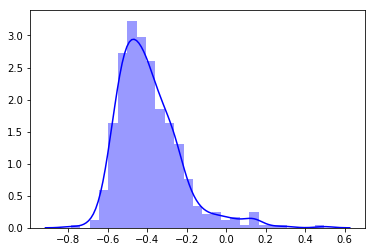

In [82]:
net_probs = []
for i in range(len(probas)):
    net_probs.append(probas.iloc[i][1] - probas.iloc[i][0]) #R minus D so that Republican == positive, 

sns.distplot(net_probs, label='rep', color='blue')
print('   net: ', sum(net_probs))
print('   mean: ', np.average(net_probs))
print('   mode: ', sp.stats.mode(net_probs))
print('   med: ', np.median(net_probs))
#plt.savefig('./Presentation/OutputFigs/demsbNet_3.png')

## Back Testing: Republican


In [83]:
data_list = []
base_url = "https://www.reddit.com/r/Republican/.json"
URL = base_url
#seems to be a cap at 20
for step in range(20):
    res = requests.get(URL, headers={'User-agent': 'Conor Barry Bot 0.1'})
    data = res.json()
    
    for i in range(len(data['data']['children'])):
        temp = {}
        temp['subreddit'] = data['data']['children'][i]['data']['subreddit_name_prefixed'].replace('r/', '')
        temp['title']=data['data']['children'][i]['data']['title']
        temp['selftext'] = data['data']['children'][i]['data']['selftext']
        data_list.append(temp)

    new_after = data['data']['after']
    URL = base_url + "?after=" + new_after
    print('    iteration {} worked. URL: {}'.format(step, URL))
    time.sleep(3)
    
df_repsb_scrape = pd.DataFrame(data_list)
print('    size: ', df_repsb_scrape.shape)
# Export to csv
df_repsb_scrape.to_csv('./Data/repsbPosts_9_04_B.csv', index=False)
df_repsb_scrape.head()

    iteration 0 worked. URL: https://www.reddit.com/r/Republican/.json?after=t3_9ce42w
    iteration 1 worked. URL: https://www.reddit.com/r/Republican/.json?after=t3_9bm6g8
    iteration 2 worked. URL: https://www.reddit.com/r/Republican/.json?after=t3_9armnk
    iteration 3 worked. URL: https://www.reddit.com/r/Republican/.json?after=t3_99x5e8
    iteration 4 worked. URL: https://www.reddit.com/r/Republican/.json?after=t3_99slzu
    iteration 5 worked. URL: https://www.reddit.com/r/Republican/.json?after=t3_98u7lv
    iteration 6 worked. URL: https://www.reddit.com/r/Republican/.json?after=t3_9823sn
    iteration 7 worked. URL: https://www.reddit.com/r/Republican/.json?after=t3_97mhps
    iteration 8 worked. URL: https://www.reddit.com/r/Republican/.json?after=t3_96m5k1
    iteration 9 worked. URL: https://www.reddit.com/r/Republican/.json?after=t3_966a6d
    iteration 10 worked. URL: https://www.reddit.com/r/Republican/.json?after=t3_95m585
    iteration 11 worked. URL: https://www.

,selftext,subreddit,title
0,,Republican,"Corporate Suicide Watch, Nike Edition"
1,,Republican,Facebook Confessed PragerU Hit by Ideological ...
2,,Republican,Former Senator Jon Kyl appointed to take McCai...
3,,Republican,"How Socialism Rots The Soul, The Culture And T..."
4,,Republican,Attend Rand Paul’s Rally for Eric Brakey’s US ...


In [93]:
#Jump into analysis for this subreddit here from here
df_data_current = pd.read_csv('./Data/repsbPosts_9_04_B.csv').loc[:, ['title']]
X_cur = latest_transform.transform(df_data_current.title).todense()
df_cur_predictions = pd.DataFrame(latest_model.predict(X_cur),
                                 columns=['Party'])

df_cur_predictions = df_cur_predictions.join(pd.DataFrame(latest_model.predict_proba(X_cur), columns = ['none_score','rep_score', 'dem_score'] ))

'''The next 3 rows mimic the output of a 2 category model with type republican =0, democrat=1. 
Since we are asking, what is the dominant party ranking for this sub, other than none, we want some intentionally biased results.'''
df_cur_predictions['NewDem'] = 1*(df_cur_predictions['dem_score'] > df_cur_predictions['rep_score']) #Score whichever is higher proba
#create 'Normalized' probabs based on the assumption that a post is either republican or democrat and never neither 
df_cur_predictions['NewDem_proba'] = df_cur_predictions['dem_score']/(df_cur_predictions['dem_score']+df_cur_predictions['rep_score'])
df_cur_predictions['NewRep_proba'] = 1 - df_cur_predictions['NewDem_proba']

#Counts
print('   None: ', len(df_cur_predictions[df_cur_predictions.Party == 0]))
print('   Rep: ', len(df_cur_predictions[df_cur_predictions.Party == 1]))
print('   Dem: ', len(df_cur_predictions[df_cur_predictions.Party == 2]))
#Average party rating across all posts
print('   Adj Dem Count: ', df_cur_predictions['NewDem'].sum())
print('   Adj Rep Count: ', df_cur_predictions['NewDem'].count() - df_cur_predictions['NewDem'].sum())
#Avg aggregate rating - >.5 indicates dem
print('   Net: ', df_cur_predictions['NewDem'].mean())

#summarize winning scores for each party 
probas = df_cur_predictions.loc[:, ['NewDem_proba', 'NewRep_proba']]
min_prob = .5
dem_probs = []
rep_probs = []
for i in range(len(probas)):
    if probas.iloc[i][1] >min_prob:
        rep_probs.append(probas.iloc[i][1])
    elif probas.iloc[i][0]>min_prob:
        dem_probs.append(probas.iloc[i][0])
print('   average dem score: ', sum(dem_probs) / len(dem_probs))
print('   average rep score: ', sum(rep_probs) / len(rep_probs))
#More republican or more dem scores?
print('   net score: ', len(rep_probs) - len(dem_probs)) 

net_probs = []
for i in range(len(probas)):
    net_probs.append(probas.iloc[i][1] - probas.iloc[i][0]) #R minus D so that Republican == positive, 

sns.distplot(net_probs, label='rep', color='blue')
print('   net sum of probas: ', sum(net_probs))
print('   mean proba delta: ', np.average(net_probs))
print('   mode: ', sp.stats.mode(net_probs))
print('   med: ', np.median(net_probs))
#plt.savefig('./Presentation/OutputFigs/repsbNet_3.png')

   None:  92
   Rep:  395
   Dem:  13
   Adj Dem Count:  24
   Adj Rep Count:  476
   Net:  0.048
   average dem score:  0.5849286053471935
   average rep score:  0.6990392395330777
   net score:  452
